# Landmarks (OSM Data)

Four scores are here computed to extract computation landmarks: structural, visual, pragmatic.
Currently, the user has to provide the building shapefile, collected independently. The height is the only necessary field, plus two datasets containing respectively information about cultural/historical landmarks (e.g. position of listed important buildings) and land-use.

In [1]:
import osmnx as ox, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

## Obtaining the Data

Fill the list 'places' with the names of the cities of interest. Buildings footprints are dowloaded for each city from OpenStreetMap within a certain distance from the centre of each city. The distance is set by the user. Each geodataframe is projected automatically (check OSMNx documentation for more information). The geodataframes are then cleaned and only relevant columns are kept. 

In [2]:
distance_from_center = 1000
places = ['London, UK', 'Torino, Italy', 'Berlin, Germany', 'Beograd, Serbia', 'New York, US', 'Cairo, Egypt']
buildings_gdfs = []

for place in places:
    buildings_gdf = ci.get_buildings_fromOSM(place, 'distance_from_address', epsg = None, distance = distance_from_center)
    buildings_gdfs.append(buildings_gdf)

**Visualisation**

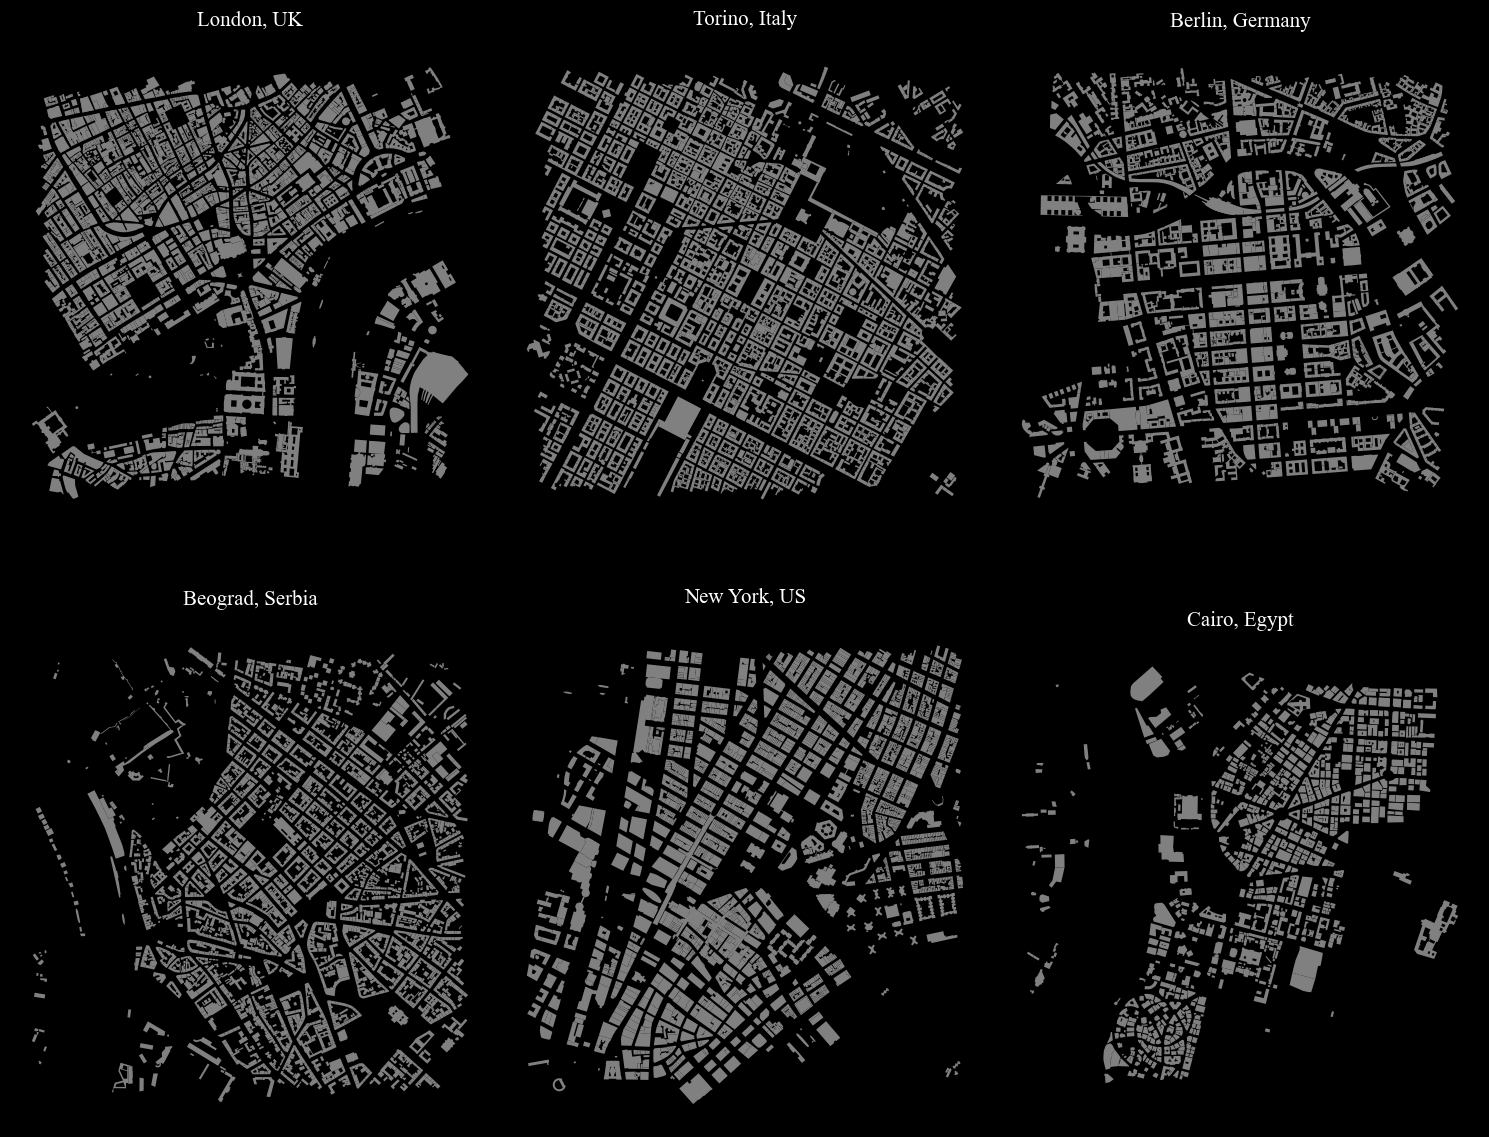

In [3]:
fig = ci.plot_grid_gdfs_column(gdfs = buildings_gdfs, titles = places, figsize = (15,15), color = 'grey', black_background = True,
                              nrows = 2, ncols = 3)

## Structural, Visual and Cultural score computations

### Structural Component

It considers:

* The area of the building.
* Its distance from the road.
* The number of adjacent buildings, within the given `neighbours_radius`, around it.
* A measure of 2d advance visibility, expanded till a maximum distance from the center of the building on the basis of the `advance_vis_expansion_distance` parameter.

In [4]:
edges_graphs = []
for n, city in enumerate(places):
    # reading the street network
    _, edges_graph = ci.get_network_fromOSM(place = city, download_method = 'distance_from_address', 
                                            distance = distance_from_center,
                                            network_type = 'walk')
    ox.projection.project_gdf(edges_graph)
    edges_graphs.append(edges_graph)

for n, city in enumerate(places):
    # structural score
    buildings = buildings_gdfs[n]
    obstructions = buildings.copy()
    edges_graph = edges_graphs[n]
    buildings_gdfs[n] = ci.structural_score(buildings, obstructions, edges_graph, advance_vis_expansion_distance = 300, 
                                neighbours_radius = 150)

## Visual Component

In [5]:
for n, city in enumerate(places):
    # visual score: not really computed at the moment as in most of the cases height information is not provided in OSM
    buildings_gdfs[n], _ = ci.visibility_score(buildings_gdfs[n])

## Cultural Component

In [6]:
for n, city in enumerate(places):
    # culturalscore:
    buildings_gdfs[n] = ci.cultural_score(buildings_gdfs[n], from_OSM = True)

## Pragmatic Score
### Land use 

In [7]:
adult_entertainment = ['brothel', 'casino', 'gambling', 'nightclub', 'private_club', 'stripclub', 'swingerclub']
agriculture = ['agricultural and forestry', 'barn', 'building in the botanical garden', 'greenhouse', 'greenhouse (botany)', 'shed', 'silo', 'stable']
attractions = ['aquarium', 'attraction', 'attraction and leisure', 'attractions', 'bath house, thermal baths', 'boathouse', 'entertainment hall', 
               'exhibition hall, trade hall', 'information', 'recreation and amusement park', 'sauna', 'terrace', 
               'tourist information center', 'viewpoint', 'zoo']
business_services = ['administrative building', 'atm', 'bank', 'bureau_de_change', 'conference_centre', 'coworking_space', 'customs office', 
                     'data_center', 'facility building', 'foundation', 'insurance', 'office', 'offices', 'post', 'post_office', 'post_office;atm', 
                     'residential building with trade and services', 'service', 'stock_exchange', 'tax office', 'tax_office', 'trade and services', 
                     'trade and services building']
commercial = ['bicycle_rental', 'boat_rental', 'boat_sharing', 'books', 'car_rental', 'car_sharing', 'car wash', 'car_wash', 'commercial', 
              'commercial and industry buidling', 'commercial and industry building', 'commercial building', 
              'commercial building to traffic facilities (general)', 'commercial land', 'commercial services', 'commercial;educa', 
              'crematorium', 'dive_centre', 'driving_school', 'fuel', 'funeral parlor', 'gas station', 'internet_cafe', 'kiosk',
              'mall', 'marketplace', 'pharmacy', 'pumping station', 'retail', 'retail;yes', 'shop', 'supermarket']
culture = ['arts_centre', 'cinema', 'club_house', 'cultural facility', 'cultural_centre', 'culture', 'exhibition_centre', 'gallery', 
           'music_school', 'museum', 'opera_house', 'planetarium', 'studio', 'theater', 'theatre']
eating_drinking = ['accommodation, eating and drinking', 'bar', 'bbq', 'biergarten', 'cafe', 'cafe;restaurant', 'fast_food', 'food_court', 
                   'ice_cream', 'kitchen', 'pub', 'restaurant']
education_research = ['education and research', 'research', 'research_institute', 'research_institu', 'university', 'university building']
emergency_service = ['emergency_service', 'fire brigade', 'fire_station', 'police', 'ranger_station', 'resque_station', 'security']
general_education = ['childcare', 'children home', 'college', 'education', 'education and health', 'general education school', 'kindergarten', 
                     'language_school', 'nursery', 'school']
hospitality = ['building for accommodation', 'guest_house', 'hostel', 'hotel', 'hotel, motel, pension', 'refuge']
industrial = ['construction', 'factory', 'gasometer', 'industrial', 'manufacture', 'manufacturing and production', 'production building', 'workshop']
medical_care = ['clinic', 'dentist', 'doctors', 'healthcare', 'hospital', 'medical care', 'mortuary', 'nursing_home', 'retirement home', 
                'sanatorium, nursing home', 'veterinary']
military_detainment = ['barracks', 'bunker', 'bunker, shelter', 'general aviation', 'military', 'penitentiary', 'prison']
monument = ['arch', 'bridge', 'castle', 'gate', 'gatehouse','monument', 'palace', 'ruins', 'tower', 'wall']
other = ['abandoned', 'air_shaft', 'block', 'boat', 'canopy', 'container', 'converter', 'exempt', 'exempt 121a', 'garage', 
         'garages', 'gazebo', 'houseboat', 'hut', 'no', 'parking', 'pavilion', 'picnic_site', 'roof', 'ship', 'shelter', 'steps', 'storage_tank', 
         'toilet', 'toilets', 'ventilation_shaft', 'viaduct', 'warehouse']
public = ['community_centre', 'civic', 'courthouse', 'district government', 'embassy', 'government', 'library', 'public', 'public infrastructure', 
          'public_building', 'residential building with public facilities', 'townhall', 'trade_union', 'yes;public']
religious = ['basilica', 'cathedral', 'chapel', 'church', 'convent', 'monastery','mosque', 'nuns home', 'place_of_worship', 'rectory', 
             'religious building', 'religious buildings', 'synagogue', 'vocational school']
residential = ['apartments', 'apartments 4-6 units', 'apartments 7 units above', 'building', 'building usage mixed with living', 
               'commercial condo unit', 'condominium master', 'condominium parking', 'detached', 'exempt', 'flats', 'house', 'houses', 
               'mixed use res/comm', 'NaN', 'residential', 'residential building', 'residential condo unit', 'residential land', 
               'residential single family', 'residential three family', 'residential two family', 'student dorm', None]
social = ['community buidling', 'community centre', 'community hall', 'commercial social facility', 'dormitory', 'recreational', 
          'social centre', 'social_facility', 'social services', 'social services building', 'society']
sport = ['bowling hall', 'grandstand', 'gym', 'horse riding school', 'indoor swimming pool', 'sport and entertainment', 
         'sport hall', 'sports building', 'sports hall', 'sports or exercise facility', 'stadium', 'swimming pool']
transport = ['bus_station', 'ferry_terminal', 'light rapid transit station', 'light rapid transit station and railway station', 
             'london underground station', 'railway building', 'railway station', 'railway station and london underground station', 'road transport', 
             'shipping facility building', 'station', 'subway_entrance', 'train_station', 'transport', 'transportation']
utilities = ['boiler house', 'electricity substation', 'electricity supply', 'electricity', 'gas supply', 'heating plant', 'smokestack',
             'supply systems', 'telecommunication', 'waste management', 'waste treatment building', 'waste water treatment plant', 'water supply', 
             'water works']

In [8]:
categories = [adult_entertainment, agriculture, attractions, business_services, commercial, culture, eating_drinking,
       education_research, emergency_service, general_education, hospitality, industrial, medical_care, military_detainment, monument,
       other, public, religious, residential, social, sport, transport, utilities]
strings = ['adult_entertainment', 'agriculture', 'attractions', 'business_services', 'commercial', 'culture', 'eating_drinking',
       'education_research', 'emergency_service', 'general_education', 'monument', 'hospitality', 'industrial', 'medical_care', 
           'military_detainment', 'other', 'public', 'religious', 'residential', 'social', 'sport', 'transport', 'utilities']

In [9]:
for n, city in enumerate(places):
    all_uses = [item for sublist in categories for item in sublist]
    land_uses = list(buildings_gdfs[n].land_use_raw.unique())
    to_categorise = [item for item in land_uses if item not in all_uses]
    print(to_categorise)

[]
[]
[]
[]
[]
[]


The `radius` parameter indicates the extension of the area that is used to compute the score of a building, on the basis of
its land-use's frequency, in an area of 'buffer' meters around it.

### Score computation

In [10]:
for n, city in enumerate(places):
    buildings_gdfs[n]['land_use_raw'] = buildings_gdfs[n]['land_use_raw'].str.lower()
    buildings_gdfs[n] = ci.classify_land_use(buildings_gdfs[n], 'land_use','land_use_raw', categories, strings)
    buildings_gdfs[n] = ci.pragmatic_score(buildings_gdfs[n], research_radius = 200)

**Visualisation**

In [11]:
nr_categories = max([len(gdf['land_use'].unique()) for gdf in buildings_gdfs])
cmap = ci.rand_cmap(nr_categories, type_color = 'bright')

In [12]:
fig = plot_grid_gdfs_column(buildings_gdfs,titles = places, cmap = cmap, column = 'land_use', nrows = 2, ncols = 3,
                              legend = True, figsize = (15,10))
plt.tight_layout(pad=3.0, rect=[0, 0, 0.85, 1])  # Adjust rect to leave space on the right
plt.show()

NameError: name 'plot_grid_gdfs_column' is not defined

## Final scores

### Weights definition.

#### Weights of components and indexes that are not computed due to data availability are set to 0

In [ ]:
# global landmarkness components weights
g_cW = {'vScore': 0.00, 'sScore' : 0.60, 'cScore': 0.10, 'pScore': 0.30}
# global landmarkness indexes weights, cScore and pScore have only 1 index each
g_iW = {'3dvis': 0.00, 'fac': 0.00, 'height': 0.00, 'area': 0.50, '2dvis': 0.00, 'neigh': 0.30 , 'road': 0.20}

# # local landmarkness components weights
l_cW = {'vScore': 0.05, 'sScore' : 0.45, 'cScore':0.10 , 'pScore': 0.45}
# # local landmarkness indexes weights, cScore and pScore have only 1 index each
l_iW = {'3dvis': 0.00, 'fac': 0.00, 'height': 0.00, 'area': 0.50, '2dvis': 0.00, 'neigh': 0.30 , 'road': 0.20}

In [ ]:
# Global and Local Score (1500 mt area)
for n, city in enumerate(places):
    buildings_gdfs[n] = ci.compute_global_scores(buildings_gdfs[n], g_iW,g_cW)
    buildings_gdfs[n] = ci.compute_local_scores(buildings_gdfs[n], l_iW, l_cW, 1500)

## Visualisation

In [ ]:
scheme_dict = {'bins' : [0.125, 0.25, 0.5, 0.75, 1.00], 'scheme' : 'User_Defined'}

fig = ci.plot_grid_gdfs_column(buildings_gdfs, main_title = 'Structural score', titles = places, classes = 7, column = 'sScore_sc', nrows = 2, ncols = 3,
                cmap = 'magma', legend = True, figsize = (10,10), **scheme_dict)
plt.tight_layout(pad=0.0, rect=[0, 0, 0.90, 1.05])
plt.show()

In [ ]:
fig = ci.plot_grid_gdfs_column(buildings_gdfs,main_title = 'Pragmatic score', titles = places, classes = 7, column = 'pScore', nrows = 2, ncols = 3,
                cmap = 'magma', legend = True, figsize = (10,10), **scheme_dict)
plt.tight_layout(pad=0.0, rect=[0, 0, 0.90, 1.05])
plt.show()

In [ ]:
fig = ci.plot_grid_gdfs_column(buildings_gdfs, main_title = 'Local score', titles = places, classes = 7, column = 'lScore_sc', nrows = 2, ncols = 3,
                cmap = 'magma', legend = True, figsize = (10,10), **scheme_dict)
plt.tight_layout(pad=0.0, rect=[0, 0, 0.90, 1.05])
plt.show()

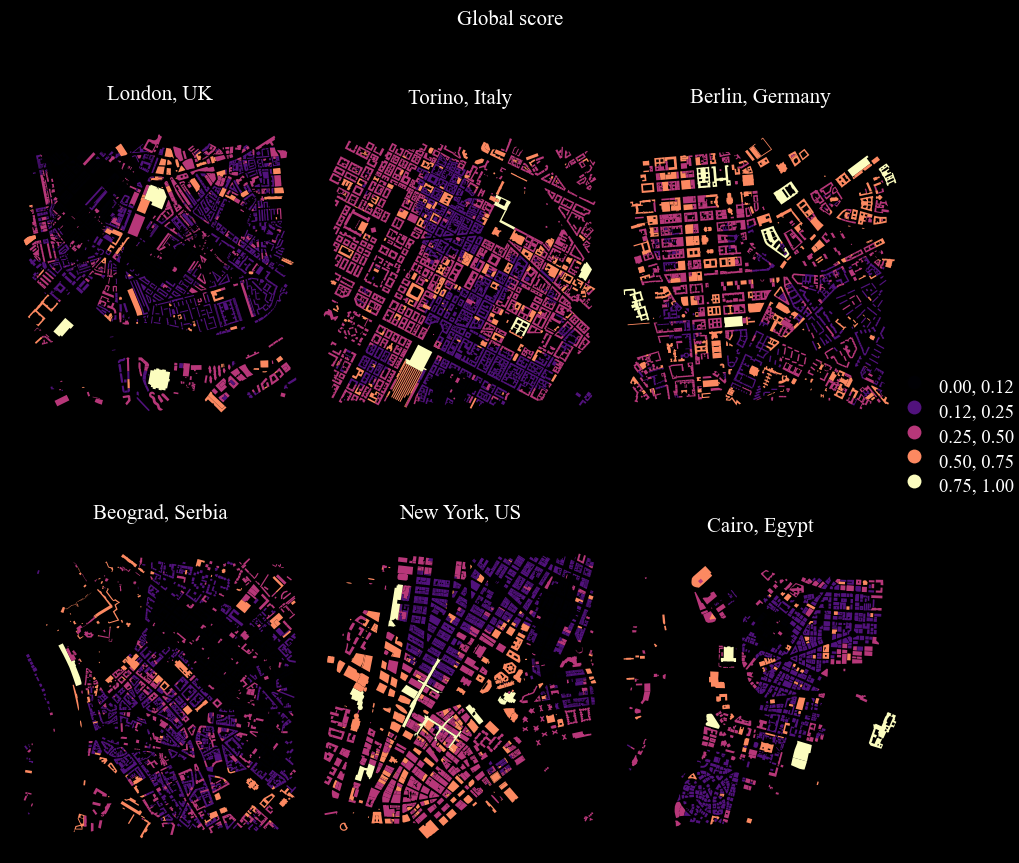

In [121]:
fig = ci.plot_grid_gdfs_column(buildings_gdfs, main_title = 'Global score', titles = places,  column = 'gScore_sc', nrows = 2, ncols = 3,
                cmap = 'magma', legend = True, figsize = (10,10), **scheme_dict)
plt.tight_layout(pad=0.0, rect=[0, 0, 0.90, 1.05])
plt.show()